# Exploring Line Lengths in Python Packages

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2017/11/09/exploring-line-lengths-in-python-packages/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The code content is MIT licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

This week, Twitter upped their single-tweet character limit from 140 to 280, purportedly based on this [interesting analysis of tweet lengths](https://blog.twitter.com/engineering/en_us/topics/insights/2017/Our-Discovery-of-Cramming.html) published on Twitter's engineering blog.
The gist of the analysis is this: English language tweets display a roughly log-normal distribution of character counts, except near the 140-character limit, at which the distribution spikes:

<img src="http://jakevdp.github.io/images/tweet_lengths.png" width=500>

The analysis takes this as evidence that twitter users often "cram" their longer thoughts into the 140 character limit, and suggest that a 280-character limit would more naturally accommodate the distribution of people's desired tweet lengths.

This immediately brought to mind another character limit that many Python programmers face in their day-to-day lives: the 79-character line limit suggested by Python's [PEP8 style guide](https://www.python.org/dev/peps/pep-0008/#maximum-line-length):

> Limit all lines to a maximum of 79 characters.

I began to wonder whether popular Python packages (e.g. NumPy, SciPy, Pandas, Scikit-Learn, Matplotlib, AstroPy) display anything similar to what is seen in the distribution of tweet lengths.

Spoiler alert: they do! And the details of the distribution reveal some insights into the programming habits and stylistic conventions of the communities who write them.

<!-- PELICAN_END_SUMMARY -->

## Counting Lines in NumPy

To take a look at this, we first need a way to access all the raw lines of code in any Python package.
In a standard system architecture, if you have installed a package you already have the Python source stored in your system.
For example, the ``numpy`` source code on my system is stored here:

In [1]:
import numpy
numpy.__path__

['/Users/jakevdp/anaconda/lib/python3.6/site-packages/numpy']

With this in mind, we can use the ``os.walk`` function to write a quick generator function that will iterate over all lines of Python code in a given package:

In [2]:
# Python 3.X
import os

def iter_lines(module):
    """Iterate over all lines of Python in module"""
    for root, dirs, files in os.walk(module.__path__[0]):
        for filename in files:
            if filename.endswith('.py'):
                with open(os.path.join(root, filename)) as f:
                    yield from f

This returns a generator expression that iterates over all lines in order; let's see how many lines of Python code NumPy contains:

In [3]:
lines = iter_lines(numpy)
len(list(lines))

179615

Given this we can find the lengths of all the lines and plot a histogram:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-whitegrid')

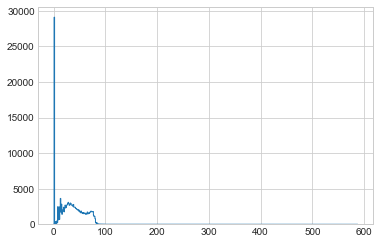

In [5]:
lengths = [len(line) for line in iter_lines(numpy)]
plt.hist(lengths, bins=np.arange(max(lengths)), histtype='step', linewidth=1);

The distribution is dominated by lines of length 1 (i.e. containing only a newline character): let's go ahead and remove these, and also narrow the x limits:

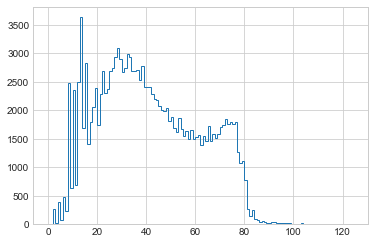

In [6]:
lengths = [len(line) for line in iter_lines(numpy) if len(line) > 1]
plt.hist(lengths, bins=np.arange(125), histtype='step', linewidth=1);

Now this is looking interesting!

## Cleaning the Distribution

The first feature that pops out to me are the large spikes between 0 and 20 characters. To explore these, let's look at the lines that make up the largest spike:

In [7]:
np.argmax(np.bincount(lengths))

13

We can use a list comprehension to extract all lines of length 13:

In [8]:
lines13 = [line for line in iter_lines(numpy) if len(line) == 13]
len(lines13)

3637

There are 3637 lines in NumPy with a length of 13 characters. It's interesting to explore how many of these short lines are identical.
The Pandas ``value_counts`` function is useful for this:

In [9]:
import pandas as pd
pd.value_counts(lines13).head(10)

    --------\n    1349
    Examples\n     646
    See Also\n     645
        try:\n     218
        pass\n      62
    See also\n      59
    return c\n      38
    return a\n      22
        None\n      20
    finally:\n      19
dtype: int64

It's clear tha many of these duplicates are just boiler-plate code or documentation standards that happen to appear often through the package; we may be able to clean up our histogram by plotting only the histogram of lengths of *unique* lines, by passing the ist through Python's ``set`` collection:

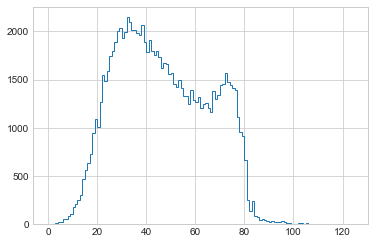

In [10]:
lengths = [len(line) for line in set(iter_lines(numpy))]
plt.hist(lengths, bins=np.arange(125), histtype='step', linewidth=1);

That's a much cleaner distribution!

## Comparison Between Packages

In order to aid comparison between packages, let's quickly refactor the above histogram code into a function that we can re-use. In addition, we'll add a vertical line at the PEP8's maximum character count:

In [11]:
def hist_linelengths(module, ax):
    """Plot a histogram of lengths of unique lines in the given module"""
    lengths = [len(line.rstrip('\n')) for line in set(iter_lines(module))]
    h = ax.hist(lengths, bins=np.arange(125) + 0.5, histtype='step', linewidth=1.5)
    ax.axvline(x=79.5, linestyle=':', color='black')
    ax.set(title="{0} {1}".format(module.__name__, module.__version__),
           xlim=(1, 100),
           ylim=(0, None),
           xlabel='characters in line',
           ylabel='number of lines')
    return h

Now we can use that function to compare the distributions for a number of well-known scientific Python packages:

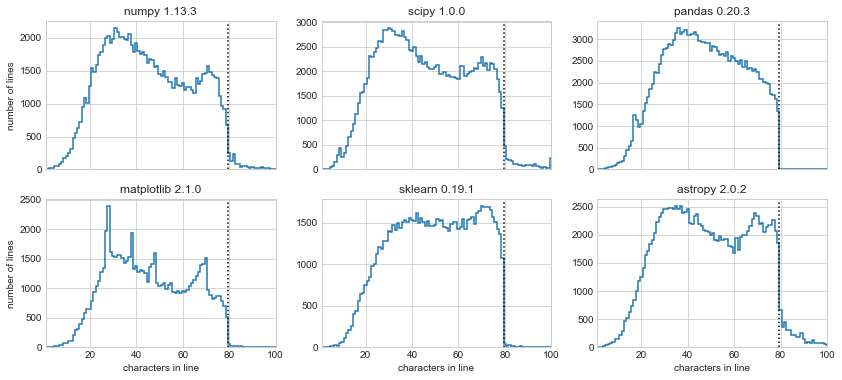

In [12]:
import numpy, scipy, matplotlib, pandas, sklearn, astropy
modules = [numpy, scipy, pandas, matplotlib, sklearn, astropy]

fig, ax = plt.subplots(2, 3, figsize=(14, 6), sharex=True)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for axi, module in zip(ax.flat, modules):
    hist_linelengths(module, ax=axi)

for axi in ax[0]:
    axi.set_xlabel('')
for axi in ax[:, 1:].flat:
    axi.set_ylabel('')

The results here are quite interesting: similar to Twitter's tweet length analysis, we see that each of these packages have a somewhat smooth distribution of characters, with a "bump" at or near the 79-character PEP8 limit!
Additionally, it is clear that some packages (namely matplotlib, sklearn, and particularly pandas) seem to be quite strict about this limit, while other packages (numpy, scipy, astropy) are a bit more lenient.

But one package stands out: matplotlib displays some noticeable spikes at a few intermediate line lengths; let's take a look at these:

In [13]:
lines = set(iter_lines(matplotlib))
counts = np.bincount([len(line) for line in lines])
np.argmax(counts)

29

The large spike reflects the approximately 2200 lines with exactly 29 characters; printing all of these and examining them is interesting:

In [14]:
[line for line in lines if len(line) == 29][:10]

['            pick(mouseevent)\n',
 "        if aspect == 'auto':\n",
 '        for a in alias_list:\n',
 "    'violet red': '#a50055',\n",
 '            cache_dir = None\n',
 "    rc('image', cmap='gray')\n",
 "    'uni2270'        : 8816,\n",
 '                x0t -= delta\n',
 '            if lolims.any():\n',
 "    'expanded'        : 700,\n"]

We see that many lines seem to be defining some dictionary of keys starting with "uni":

In [15]:
[line for line in lines if 'uni203' in line]

["    'uni2035'        : 8245,\n",
 "    'uni203E'        : 8254,\n",
 "    'uni2033'        : 8243,\n",
 "    'uni2031'        : 8241,\n",
 "    'uni2037'        : 8247,\n",
 "    'uni203B'        : 8251,\n",
 "    'uni2034'        : 8244,\n",
 "    'uni2032'        : 8242,\n",
 "    'uni203C'        : 8252,\n",
 "    'uni2036'        : 8246,\n",
 "    'uni2038'        : 8248,\n"]

This turns out to be some auto-generated code [mapping unicode strings to numbers](https://github.com/matplotlib/matplotlib/blob/38be7aeaaac3691560aeadafe46722dda427ef47/lib/matplotlib/_mathtext_data.py).
Other spikes in the matplotlib are due to similar artifacts.

There is also the mini-dropoff at line lengths of 70; I've not looked into it, but my suspicion is that might be a remnant of the code style used by matplotlib's creator in the early days of the package.

## Modeling the Line Length Distribution

Following the Twitter character analysis, let's see if we can fit a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) to the number of lines with each character count.
As a reminder, the log-normal can be parametrized like this:

$$
LogNorm(x; \mu, \sigma) = \frac{1}{x \sigma \sqrt{2\pi}} \exp\left(-\frac{[\log(x) - \mu]^2}{2\sigma^2}\right)
$$

Here $x$ is the number of counts, $\exp(\mu)$ is the median of the peak of the distribution, and $\sigma^2$ controls the distribution's width.
We can implement this using the ``lognorm`` distribution available in scipy:

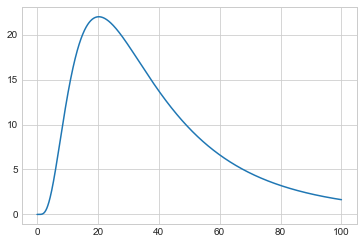

In [16]:
from scipy import stats

def lognorm_model(x, amplitude, mu, sigma):
    return amplitude * stats.lognorm.pdf(x, scale=np.exp(mu), s=sigma)

x = np.linspace(0, 100, 1000)
plt.plot(x, lognorm_model(x, 1000, 3.5, 0.7));

That seems like an appropriate shape for the left portion of our datasets; let's try optimizing the parameters to fit the counts of lines up to length 50:

optimal parameters: [  9.92126791e+04   3.75476977e+00   5.19760726e-01]


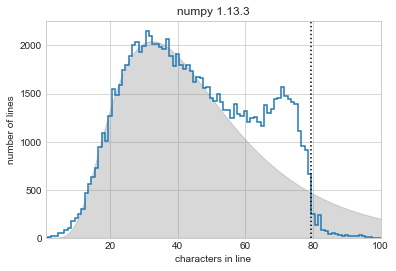

In [17]:
from scipy import optimize

counts, bins, _ = hist_linelengths(numpy, ax=plt.axes())
lengths = 0.5 * (bins[:-1] + bins[1:])

def minfunc(theta, lengths, counts):
    return np.sum((counts - lognorm_model(lengths, *theta)) ** 2)

opt = optimize.minimize(minfunc, x0=[10000, 4, 1],
                        args=(lengths[:50], counts[:50]),
                        method='Nelder-Mead')
print("optimal parameters:", opt.x)

plt.fill_between(lengths, lognorm_model(lengths, *opt.x), alpha=0.3, color='gray');

Seems like a reasonable fit! From this, you could argue (as the Twitter engineering team did) that the line lengths might "naturally" follow a log-normal distribution, if it weren't for the artificial imposition of the PEP8 maximum line length.

For convenience, let's create a function that will plot this lognormal fit for any given module:

In [18]:
def lognorm_model(x, theta):
    amp, mu, sigma = theta
    return amp * stats.lognorm.pdf(x, scale=np.exp(mu), s=sigma)

def minfunc(theta, lengths, freqs):
    return np.sum((freqs - lognorm_model(lengths, theta)) ** 2)

def lognorm_mode(amp, mu, sigma):
    return np.exp(mu - sigma ** 2)

def lognorm_std(amp, mu, sigma):
    var = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
    return np.sqrt(var)

In [19]:
def hist_linelengths_with_fit(module, ax, indices=slice(50)):
    counts, bins, _ = hist_linelengths(module, ax)
    lengths = 0.5 * (bins[:-1] + bins[1:])
    opt = optimize.minimize(minfunc, x0=[1E5, 4, 0.5],
                            args=(lengths[indices], counts[indices]),
                            method='Nelder-Mead')
    model_counts = lognorm_model(lengths, opt.x)
    ax.fill_between(lengths, model_counts, alpha=0.3, color='gray')
    
    # Add text describing mu and sigma
    
    A, mu, sigma = opt.x
    mode = np.exp(mu - sigma ** 2)
    ax.text(0.22, 0.15, 'mode = {0:.1f}'.format(lognorm_mode(*opt.x)),
            transform=ax.transAxes, size=14)
    ax.text(0.22, 0.05, 'stdev = {0:.1f}'.format(lognorm_std(*opt.x)),
            transform=ax.transAxes, size=14)
    
    return opt.x

Now we can compare the models for each package:

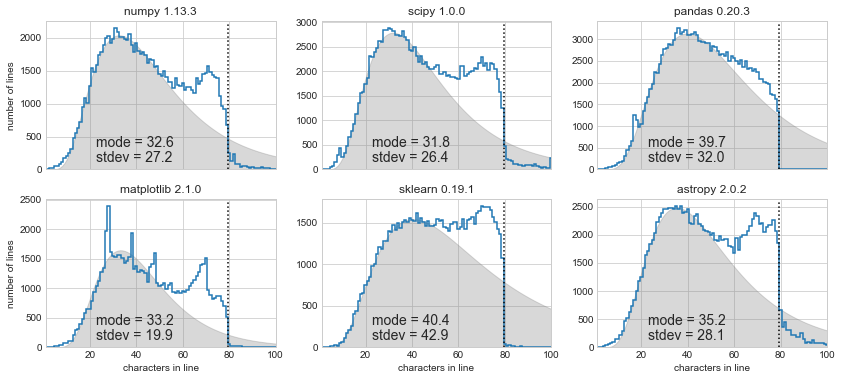

In [20]:
modules = [numpy, scipy, pandas, matplotlib, sklearn, astropy]

fig, ax = plt.subplots(2, 3, figsize=(14, 6), sharex=True)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

fits = {}

for axi, module in zip(ax.flat, modules):
    fits[module.__name__] = hist_linelengths_with_fit(module, ax=axi)
    

for axi in ax[0]:
    axi.set_xlabel('')
for axi in ax[:, 1:].flat:
    axi.set_ylabel('')

It is also interesting to use these summary statistics as a way of describing the "essence" of each package, in order to compare them directly:

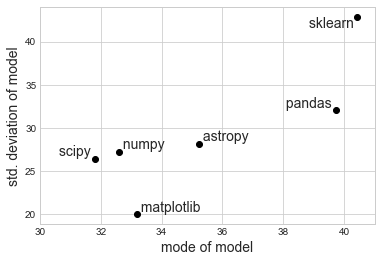

In [21]:
ha = {'sklearn': 'right', 'scipy': 'right', 'pandas': 'right'}
va = {'sklearn': 'top'}
for name, fit in sorted(fits.items()):
    mode = lognorm_mode(*fit)
    std = lognorm_std(*fit)
    plt.plot(mode, std, 'ok')
    plt.text(mode, std, ' ' + name + ' ', size=14,
             ha=ha.get(name, 'left'), va=va.get(name, 'bottom'))
plt.xlabel('mode of model', size=14)
plt.ylabel('std. deviation of model', size=14);
plt.xlim(30, 41);

## Discussion

I found it curious that a log-normal distribution fits both tweets and lines of code. Doing some digging, I found some [literature on the subject](https://epjdatascience.springeropen.com/articles/10.1140/epjds14) of message lengths on the internet. This study finds that across languages and mediums, comment lengths follow a log-normal distribution quite closely. They propose a mechanism related to the [Weber-Fechner law](https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law), which suggests a logarithmic scale in degrees of perception. It seems reasonable that lengths of code lines would respond to the same mechanism.

As for the data, I think it's quite interesting what this reveals about each project's commitment to the PEP8 line length.
Pandas, Scikit-Learn, and Matplotlib seem to be strongly committed to keeping their lines below 79 characters; by contrast, AstroPy doesn't seem to mind the occasional long line (though it does still display a "cramming" pattern, to use the parlance of the Twitter team's analysis).

Comparing the summary statistics between packages, it is interesting to note the relative similarity of the numpy and scipy packages in terms of distribution of line lengths. This makes a lot of sense, because historically the development team has overlapped strongly between these two packages.

By contrast, scikit-learn tends to have around 10 more characters per line, and a much wider distribution of typical line lengths. I suspect the length of the lines is due to the nature of scikit-learn's code: it has relatively long class names (e.g. ``RandomForestClassifier``) which are used frequently throughout the code. The prevalence of classes also adds a four-space indentation to much of the package.
As for the larger standard deviation, this may be due to the larger pool of contributors: scikit-learn has about twice the total number of contributors as either numpy or scipy.

Pandas is interesting in that it doesn't show the pronounced "cramming" effect seen in the other packages. Long lines seem to be broken-up in a more distributed way, perhaps through assignment of temporary variables rather than through line breaks.

Each package displays a distinct "fingerprint" regarding the lengths of code lines, and the above visualizations suggest that PEP8's restrictions really do affect the way people write code, particularly in packages that use more characters per line, such as Pandas and Scikit-Learn.

Keep in mind that all of this is based on a couple fairly strong assumptions:

1. PEP8 aside, the "natural" distribution of line lengths is log-normal
2. We can meaningfully extrapolate from the frequency of lines with fewer than 50 characters to find statistics describing this "natural" log-normal distribution.

We *could* follow the lead of the Twitter engineering team, and use this analysis to argue that the PEP8 line length limit should be lifted, so as to not constrain people's "natural" inclinations toward the top end of each distribution. But I think that good arguments can be made, in both the case of PEP8 and Twitter's character limit, that this is too eager an interpretation.

Those controversies aside, it would be interesting to dive a bit deeper into this kind of analysis. I can think of a few interesting question you could ask:

- Where do other Python packages fit on the mode/spread graph?
- Has the coding style in these packages, reflected in line length, evolved over time?
- How do individual contributors behave? Do they tend to have similar habits across packages?
- What do these distributions look like for code written in other languages?

All of these would be interesting to address, but I've spent enough words on this already: I'll leave those questions for another time, or another person. Thanks for reading!

*This post was written entirely in the Jupyter notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/PEP8LineLengths.ipynb)
this notebook, or see a static view
[on nbviewer](http://nbviewer.jupyter.org/url/jakevdp.github.io/downloads/notebooks/PEP8LineLengths.ipynb).*